#### **Data Description**: This data contains direct marketing campaign (phone calls) of a Portugese banking institution from May 2008 to November 2010.

* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:

* 8 - contact: contact communication type (categorical: 'cellular','telephone') 
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:

* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes

* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [79]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
import seaborn as sns
# sns.set_style('whitegrid')
from datetime import datetime
import missingno as msno
import matplotlib.ticker as ticker
from scipy import stats
from time import sleep
import teradatasql

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, recall_score, classification_report, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
# from imblearn.over_sampling import SMOTE
import itertools
import xgboost as xgb

In [81]:
os.listdir(os.getcwd() + '\\data')

['bank-full.csv', 'bank.csv']

In [82]:
df = pd.read_csv(os.getcwd() + '\\data\\bank-full.csv', sep = ';')

In [83]:
df.shape

(45211, 17)

In [84]:
df.select_dtypes('int64','float64').describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [85]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Chi-square Test of Independence

$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad H_0:$ The categorical variables are independent 
$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad H_1:$ The categorical variables are not independent 

$$ X^2 = \frac{(observed - expected)^2} {(expected)}  $$

In [86]:
def chi2_test(df, col1, col2):
    
    # Contingency table
    ct = pd.crosstab(df[col1], df[col2], margins = True)
    
    print('Test for independence between {} and {}'.format(col1, col2))
    chi2_statistic, p_value, df, expected_table = stats.chi2_contingency(ct)
    print('The chi-square statistic is {}'.format(chi2_statistic))
    print('The p-value for the test is {}'.format(p_value))
    print('The degree of freedom is {}'.format(df))
    
    if p_value < 0.05:
        print('We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent')
    else:
        print('We fail to reject the null hypothesis')

In [87]:
def plot_missing(df = df):
    
    fig, ax = plt.subplots(figsize = (15,8))
    miss = df.apply(lambda x: x.isnull().sum() / len(df)).sort_values(ascending = False)

    # Formatting ax
    ax = sns.barplot(y = miss.values, x = miss.index)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2%'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_ylim(0,1)  
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    ax.set_ylabel('Percentage of Missing')

    # formatting ax2
    ax2 = ax.twinx()
    ax2.set_ylim(0, len(df))
    ax2.set_ylabel('Count of Missing')

    # Use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10000))
    ax2.set_yticklabels(['{:,.0f}K'.format(x/1000) for x in ax2.get_yticks()])

    plt.title('Missing Value')
    fig.tight_layout()
    sns.despine()
    plt.show()

In [88]:
def plot_unique(df, col, show_count = False, show_percent = False, fontsize = 15, figsize = (15,8), hue = None): 
    
    fig, ax = plt.subplots(figsize = figsize)
    
    ax = sns.countplot(x = col, hue = hue, data = df)
    
    # show exact number on each bar
    if show_count:
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points')
    else:
        pass
    
    # show percentages on each bar
    if show_percent:
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 200, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 200, '{0:.0%}'.format(height_r/total), ha="center")
    else:
        pass

    ax.set_title('{} Count distribution'.format(col), fontsize = fontsize)
    
    if hue != None:
         plt.legend(loc = 'upper right', frameon = False)
    else:
        pass
    
    fig.tight_layout()
    sns.despine()
    plt.show()

In [89]:
def plot_distribution(df, col, figsize = (15,8)):
    
    fig, axes = plt.subplots(nrows = 2, figsize = figsize)
    
    for _ in df.target.unique():
        sns.distplot(df[df.target == _][col], hist = True, rug = False, label = _)
    
    ax = sns.boxplot(x = 'target', y = col, data = df, ax = axes[0])
    
    plt.legend(loc = 'upper right', frameon = False)
    ax.set_title('distribution of {} by response group'.format(col))
    
    fig.tight_layout()
    sns.despine(left = True)
    plt.show()

In [90]:
def plot_roc(X_test, y_test, algo):
    '''
    This function plots the ROC curve for an algorithm
    
    '''
    probs = algo.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3f}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [92]:
def plot_confusion(thresh, algo):
    ''' 
    This function plot the confusion matrix
    
    '''
    probs = algo.predict_proba(X_test)
    y_pred = [1 if x > thresh else 0 for x in probs[:,1]]
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['0', '1'], )
    pr, tpr, fpr = show_data(cm, print_res = 1)

In [174]:
def Find_Optimal_Cutoff(target, predicted, plot = True):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    optimal = list(roc_t['threshold'])[0]
    # print('The optimal cutoff that maximum tpr - fpr is {:.3f}'.format(optimal))
    
    if plot == True:
        fig, ax = plt.subplots(figsize = (8,5))
        sns.lineplot(x = threshold, y = tpr, label = 'True Positive Rate (TP/TP + FN)')
        sns.lineplot(x = threshold, y = 1 - fpr, label = '1 - False Positive Rate (TN/FP + TN)')
        
        plt.xlim(0,1)
        plt.axvline(x = optimal_cutoff, ymin = 0, ymax = 1, color = 'red')
        plt.text(optimal_cutoff + 0.03, 0.2, s = 'Optimal Cutoff: {:.3f}'.format(optimal))
        plt.title('')
        plt.ylabel('Rate')
        plt.xlabel('Threshold')
        sns.despine()
        plt.show()
    
    return optimal

#### EDA

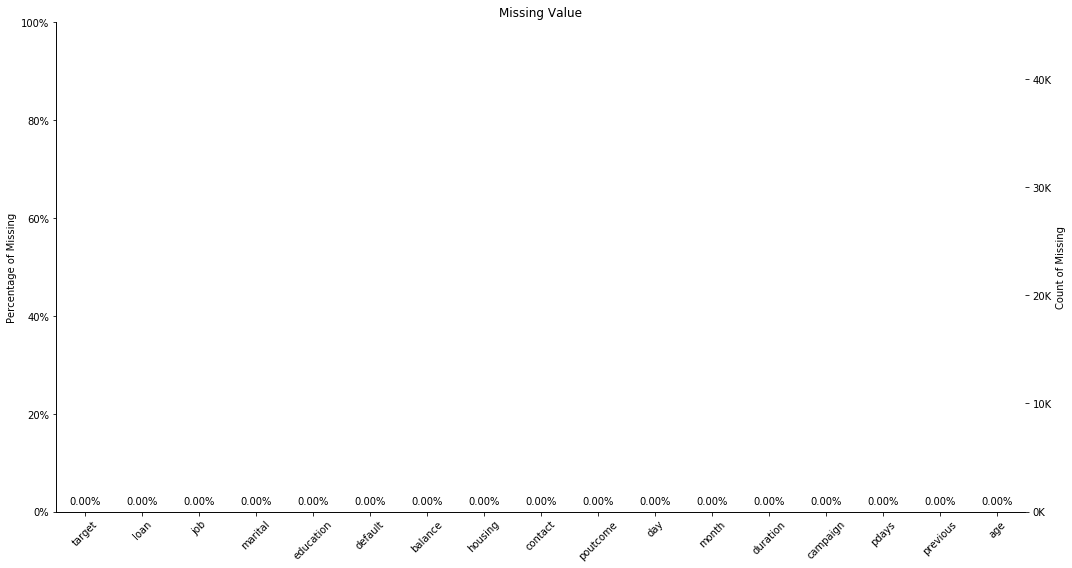

In [178]:
plot_missing(df)

In [179]:
df.drop_duplicates().shape

(45211, 17)

* There are no duplicated values

In [104]:
df.dtypes.value_counts()

object    9
int64     8
dtype: int64

* There are 9 categorical variables and 8 numeric variables which need to be dealt seperately.

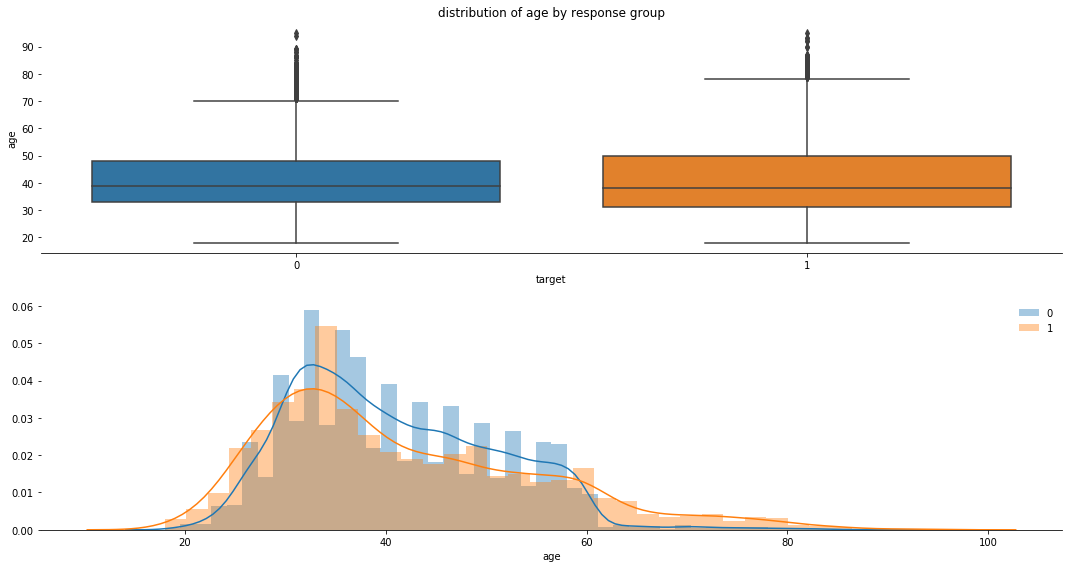

In [105]:
plot_distribution(df,'age', figsize = (15,8))

* It appears that there are some outliers which leads to the skew of the distribution. 

In [20]:
age_mean, age_std = np.mean(df.age), np.std(df.age)
min_cutoff, max_cutoff = (age_mean - 2 * age_std, age_mean + 2 * age_std)

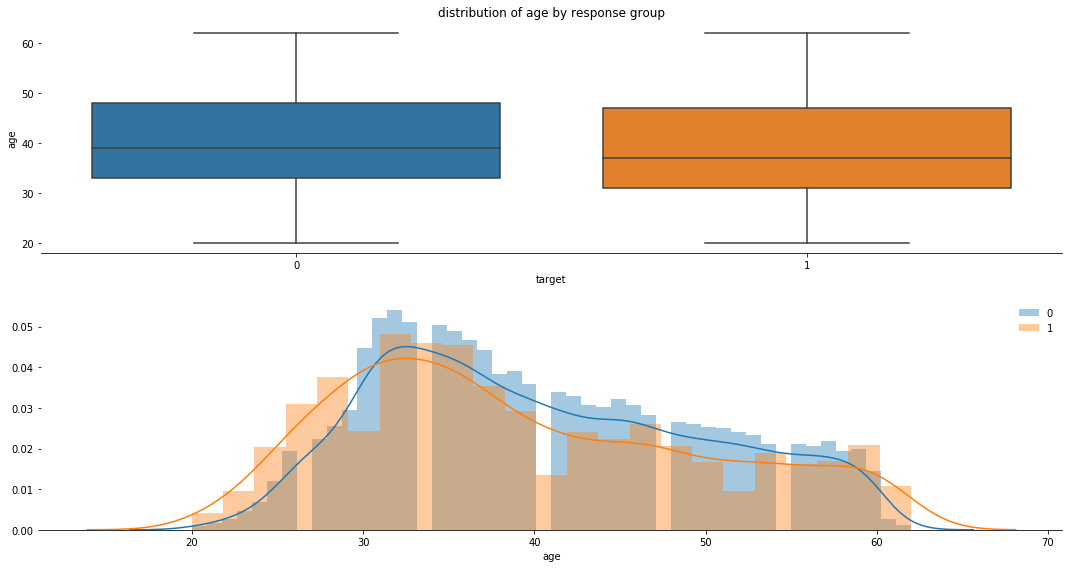

In [21]:
plot_distribution(df[(df.age > min_cutoff) & (df.age < max_cutoff)], 'age')

#### `duration`

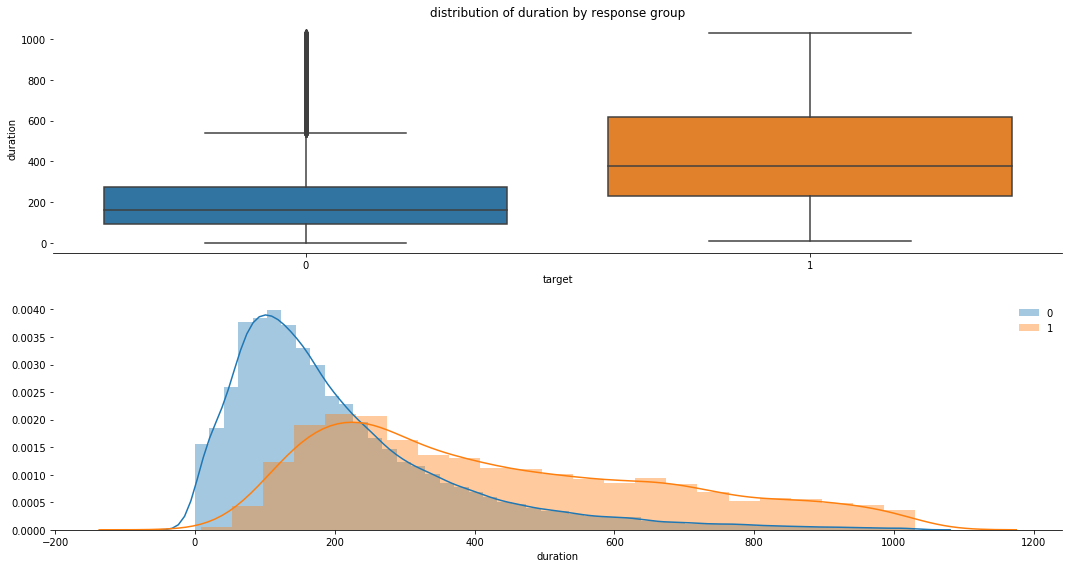

In [22]:
from scipy import stats
plot_distribution(df[np.abs(stats.zscore(df['duration'])) < 3], 'duration')

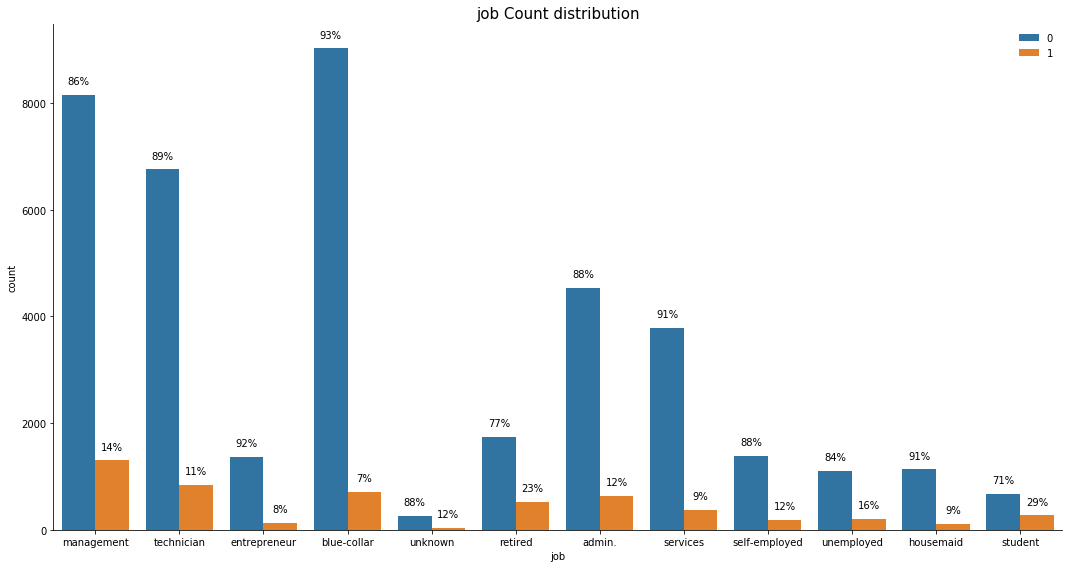

Test for independence between job and target
The chi-square statistic is 836.1054877471965
The p-value for the test is 4.85219268619098e-161
The degree of freedom is 24
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


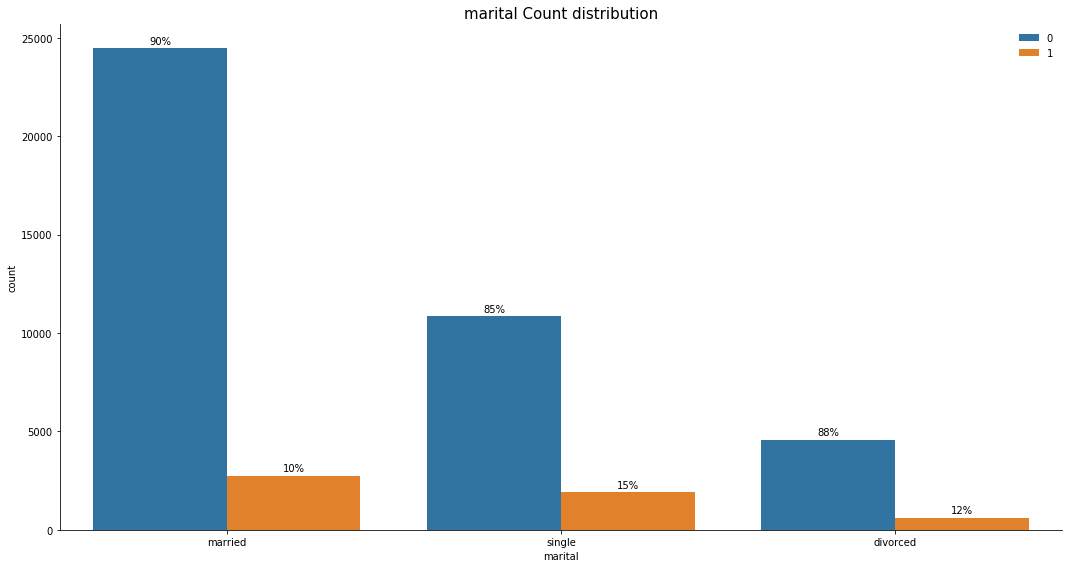

Test for independence between marital and target
The chi-square statistic is 196.4959456560396
The p-value for the test is 1.0565861769980075e-39
The degree of freedom is 6
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


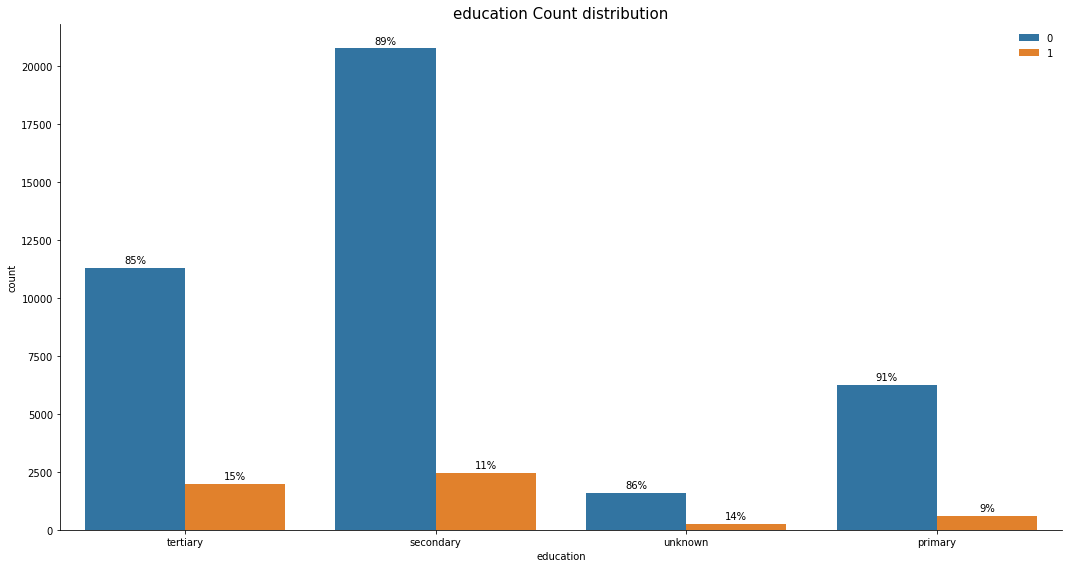

Test for independence between education and target
The chi-square statistic is 238.92350616407606
The p-value for the test is 3.8274224361043847e-47
The degree of freedom is 8
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


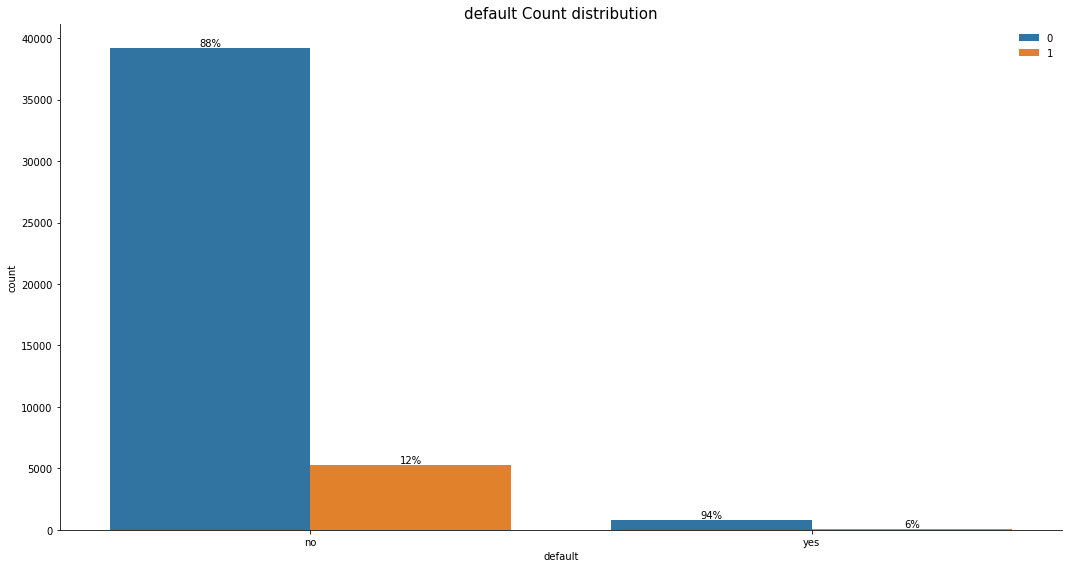

Test for independence between default and target
The chi-square statistic is 22.72350213915002
The p-value for the test is 0.00014379182626542424
The degree of freedom is 4
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


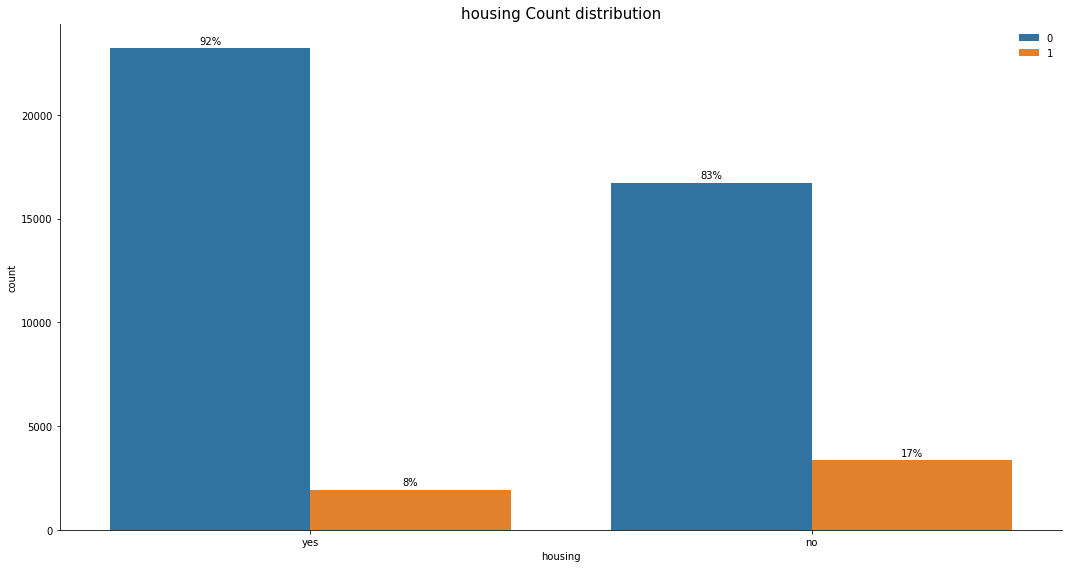

Test for independence between housing and target
The chi-square statistic is 875.6937181054402
The p-value for the test is 3.074950925518164e-188
The degree of freedom is 4
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


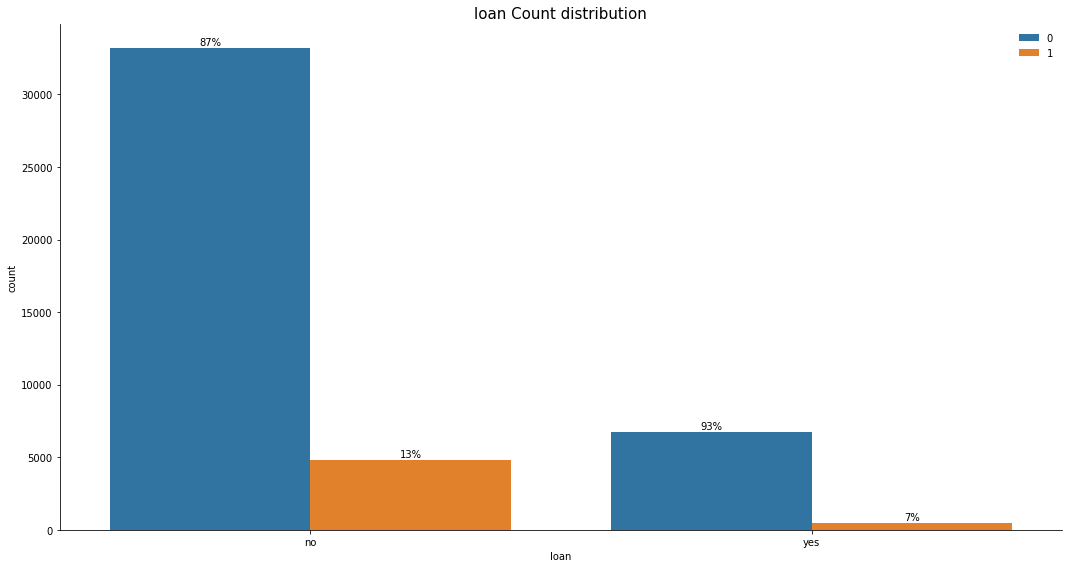

Test for independence between loan and target
The chi-square statistic is 210.19493419602674
The p-value for the test is 2.4124315150387255e-44
The degree of freedom is 4
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


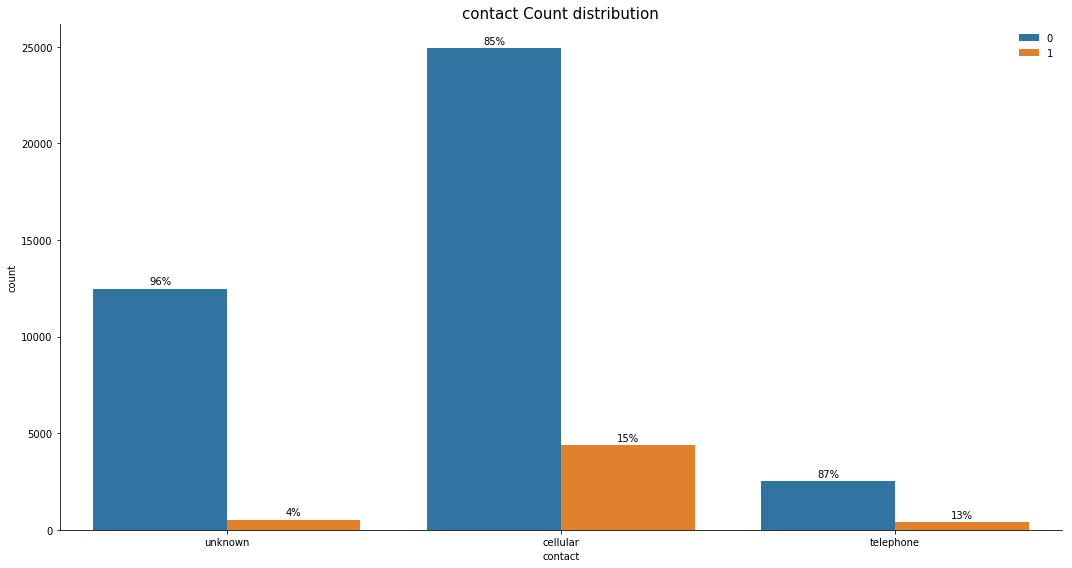

Test for independence between contact and target
The chi-square statistic is 1035.7142253562922
The p-value for the test is 1.684925551117382e-220
The degree of freedom is 6
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


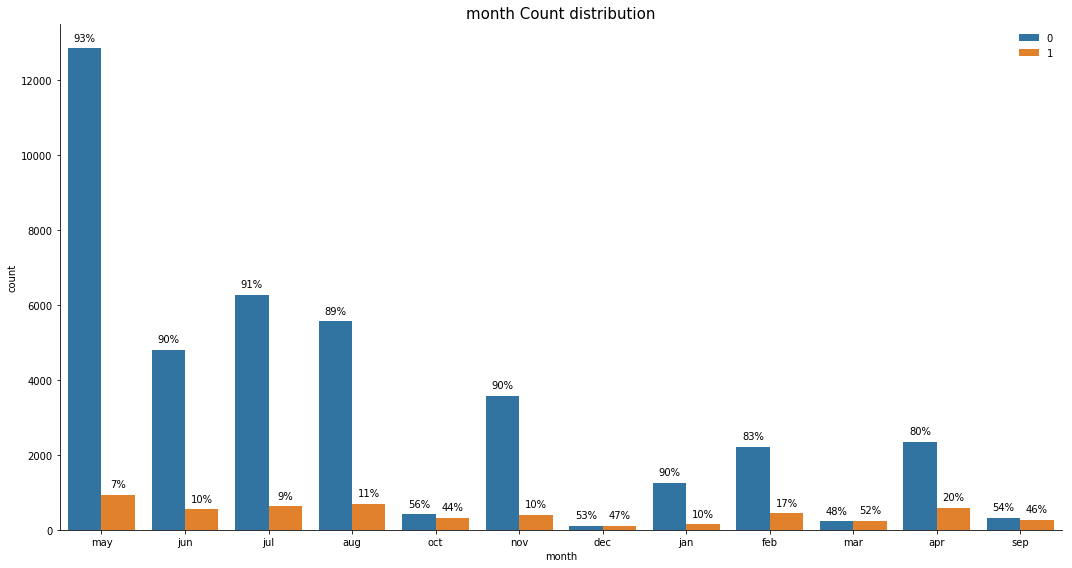

Test for independence between month and target
The chi-square statistic is 3061.8389384452694
The p-value for the test is 0.0
The degree of freedom is 24
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


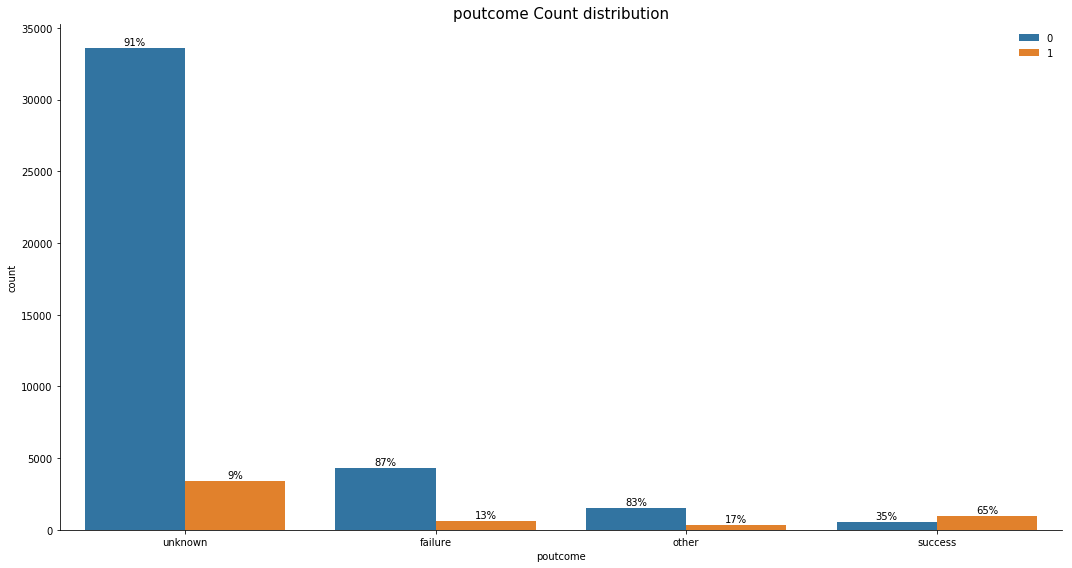

Test for independence between poutcome and target
The chi-square statistic is 4391.5065887686615
The p-value for the test is 0.0
The degree of freedom is 8
We reject the null hypothesis at 5% significant level, and conclude that the variables are not independent


In [23]:
for _ in df.select_dtypes(include = 'object').columns.tolist():
    plot_unique(df, _, show_percent = True, hue = 'target', figsize = (15,8))
    chi2_test(df, _, 'target')

#### Data Preprocessing

In [95]:
df['target'] = df['y']
df.drop('y', axis = 1, inplace = True)

In [96]:
mapper = {'yes':1, 
          'no':0}

df.target = df.target.replace(mapper)

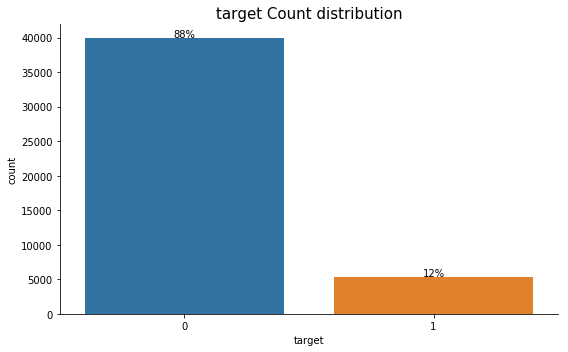

In [106]:
plot_unique(df,'target',show_percent = True, figsize = (8,5))

* First of all, we convert the target variable which indicates whether a customer responds to the marketing campaign. 1 for respond and 0 for not responding.
* In this dataset, there are around 5,289 positive values and 39,922 negative values.

In [64]:
def preprocessing(temp_df, scale = False, OneHotEncoder = False):
    
    num_col = ['balance', 'duration', 'campaign', 'pdays', 'previous']
    cat_col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
    target_col = ['target']
    
    temp_df = temp_df[num_col + cat_col + target_col + ['age']]
    
    # add age_group category
    temp_df['age_group'] = pd.qcut(temp_df['age'], 4, labels = [1,2,3,4])
    temp_df = temp_df.drop('age', axis = 1)
    
    # standardization
    if scale:
        sc = StandardScaler()
        temp_df[num_col] = sc.fit_transform(temp_df[num_col])
        
    # dummy coding
    if OneHotEncoder:
        dummy_df = pd.get_dummies(temp_df[cat_col + ['age_group']])
        temp_df = pd.concat([temp_df, dummy_df], axis = 1)
        temp_df = temp_df.drop(cat_col, axis = 1)

    return temp_df

In [99]:
df_final = preprocessing(df, scale = True, OneHotEncoder = True)

#### Model Evaluation

In [101]:
X = df_final.drop('target', axis = 1)
y = df_final['target']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 123)

In [102]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

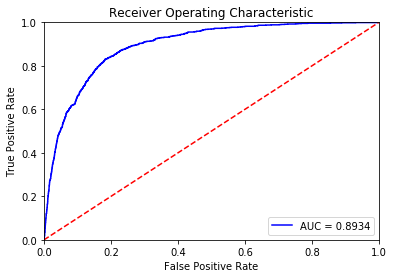

In [175]:
plot_roc(X_test, y_test, lr)

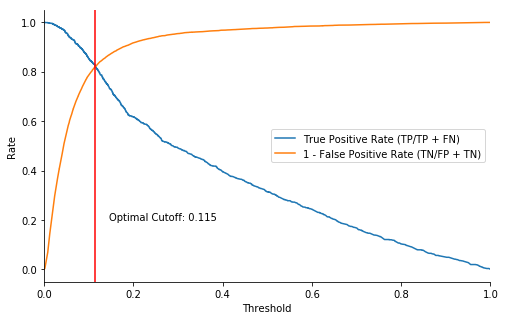

In [176]:
optimal_cutoff = Find_Optimal_Cutoff(y_test, preds)

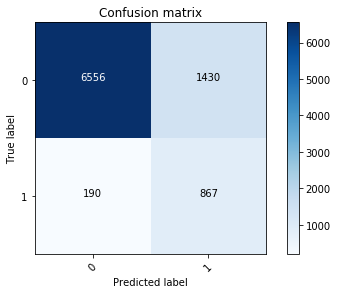

Precision =     0.377
Recall (TPR) =  0.820
Fallout (FPR) = 0.179


In [177]:
plot_confusion(thresh = optimal_cutoff, algo = lr)

#### H2O

* H2O is a Java-based 